In [1]:
### Loading Credentials from local file; 
### this cell is meant to be deleted before publishing
import yaml

with open("../creds.yml", 'r') as ymlfile:
    cfg = yaml.safe_load(ymlfile)

uri = cfg["sonar_creds"]["uri"]
user = cfg["sonar_creds"]["user"]
password = cfg["sonar_creds"]["pass"]

<font size = "20"> SoNAR (IDH) - HNA Curriculum </font>

<font size = "5">Notebook 5:  Example Case - History of Economics</font>

This notebook provides an example of a hypothesis lead approach to work with the SoNAR (IDH) data for historical network analysis. 

In this notebook we investigate an example case in the field of economics. We are going to analyze the network of the German economist [Gustav von Schmoller](https://en.wikipedia.org/wiki/Gustav_von_Schmoller).

In this notebook we follow a more hypothesis driven and ego-centered graph approach to analyze the network of interest. 

We want to investigate two main questions: 

1. What are the connections of Gustav von Schmoller to Berlin Politics?
2. How well was Schmoller connected within the academic community?

In [50]:
import networkx as nx
from neo4j import GraphDatabase
from helper_functions.helper_fun import to_nx_graph
import matplotlib.pyplot as plt
import pandas as pd

# Who is Gustav von Schmoller?

Let's start off by gathering some general information about Schmoller. What was his profession? Where did he come from? Where did he work?

## When did Schmoller live?

In [11]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

In [38]:
print("Date of Birth of Schmoller:", list(nx.get_node_attributes(G, "DateStrictBegin").values())[0])
print("Date of Death of Schmoller:", list(nx.get_node_attributes(G, "DateStrictEnd").values())[0])

Date of Birth of Schmoller: 24.06.1838
Date of Death of Schmoller: 27.06.1917


Gustav von Schmoller lived in the 19th and the beginning of the 20th century and was 79 years old when he died.

## What was Schmollers profession? 

Now we know when Schmoller lived, but what was his profession? 

In [39]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:RelationToTopicTerm]-(t:TopicTerm)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

In [40]:
topicterms = [x for x,y in G.nodes(data=True) if y['type']=="TopicTerm"]

for term in topicterms:
    print(G.nodes(data=True)[term]["Name"])

Volkswirt
Wirtschaftswissenschaftler
Sozialwissenschaftler
Hochschullehrer


Schmoller was an academic, he is was (macro) economic, social scientist and university professor.

## What geographic places are connected to Schmoller?

What are the places Schmoller has connections to? Where did he work? Where was he born and where did he die?

In [41]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:RelationToGeoName]-(g:GeoName)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

In [5]:
place_of_birth = [target for source, target, attribute in G.edges(data=True) if attribute['SourceType'] == 'placeOfBirth']
place_of_death = [target for source, target, attribute in G.edges(data=True) if attribute['SourceType'] == 'placeOfDeath']
places_of_activity = [[source, target] for source, target, attribute in G.edges(data=True) if attribute['SourceType'] == 'placeOfActivity']

# we need to refine the result of the places of activity a little further
# currently there can be the node (2923000) of Schmoller in the results. Therefor we need to filter out the node of him
places_of_activity = [place for sublist in places_of_activity for place in sublist if place != 2923000]

# let's print the results:
print("Place of Birth:", G.nodes(data=True)[place_of_birth[0]]["Name"])
print("Place of Death:",G.nodes(data=True)[place_of_death[0]]["Name"])
print("")
print("Places of Activity:")
for place in places_of_activity:
    print(G.nodes(data=True)[place]["Name"])

Place of Birth: Heilbronn
Place of Death: Bad Harzburg

Places of Activity:
Straßburg
Halle (Saale)
Berlin


He was born in Heilbronn and he died in Bad Harzburg. He has professional connections to Straßburg, Halle (Saale) and Berlin. 

## With whom was Schmoller in contact?

Schmoller was an academic, he was a university professor and he lived in different places during his life. This sounds like he was able to build quite some connections during his life. 

Let's see if this assumption is true. To which persons did Schmoller have direct connections according to the SoNAR database?

In [47]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:SocialRelation]-(n2:PerName)-[rel2]-(t:TopicTerm)
WHERE n.Id = "(DE-588)118609378" AND rel.SourceType = "correspondedRelation"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

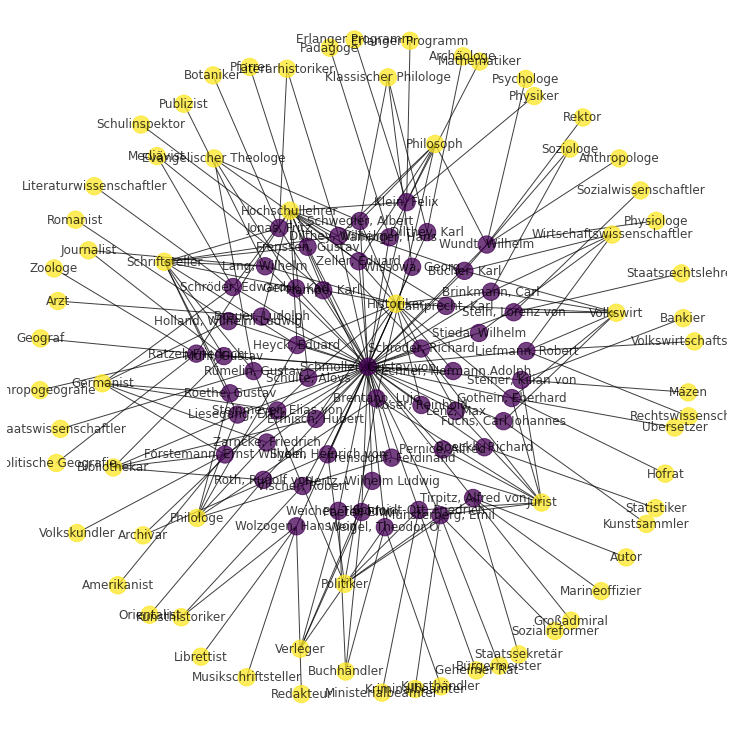

In [79]:
from itertools import count

pos = nx.kamada_kawai_layout(G)
plt.rcParams['figure.figsize'] = [10, 10]

node_labels_names = nx.get_node_attributes(G, "Name")
node_labels_titles = nx.get_node_attributes(G, "Title")
node_labels = {**node_labels_names, **node_labels_titles}

groups = set(nx.get_node_attributes(G,'type').values())
mapping = dict(zip(sorted(groups),count()))
color_map = [mapping[G.nodes()[n]['type']] for n in G.nodes()]

node_types = nx.get_node_attributes(G, "type")

edge_labels = nx.get_edge_attributes(G, "SourceType")

nx.draw(G, pos = pos, labels = node_labels, alpha = 0.75, node_color = color_map)
#nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, label_pos=0.5)

plt.show()

We can tell from the network visualization that Schmoller had a lot of connections to a lot of academics from a wide range of different scientific fields. 

Let's get a more precise overview of his connections by aggregating the connected `topicTerms` of the persons he had relationships with. 
Let's create a data frame that provides us the information about the node type and the node label (name) of each of the nodes:

In [117]:
types_dict = nx.get_node_attributes(G, "type")
label_dict = nx.get_node_attributes(G, "label")

types_df = pd.DataFrame.from_dict(types_dict, orient="index", columns=["type"])
label_df= pd.DataFrame.from_dict(label_dict, orient="index", columns=["label"])

schmoller_contacts_df = pd.concat([types_df, label_df], axis=1)
schmoller_contacts_df

,type,label
2923000,PerName,"Schmoller, Gustav von"
2834694,PerName,"Liesegang, Erich"
51586460,TopicTerm,Bibliothekar
51565992,TopicTerm,Schriftsteller
51623002,TopicTerm,Philologe
...,...,...
51560168,TopicTerm,Autor
2854581,PerName,"Weicher, Theodor"
3005380,PerName,"Steiner, Kilian von"
51745298,TopicTerm,Mäzen


The next step we need to do is filtering for all `TopicTerm` nodes and calculating the degree centrality for each of the nodes. 

In [136]:
# create new df with those rows only that have a type of "TopicTerm"
topicterms_df = schmoller_contacts_df[schmoller_contacts_df["type"] == "TopicTerm"]

# create a dictionary that contains all the degree values of the topic terms
degree_dict = dict(G.degree(topicterms_df.index.tolist()))

# make a dataframe out of the degree dictionary
degree_df = pd.DataFrame.from_dict(degree_dict, orient="index", columns=["degree"])

# add the degree values as a new variable to the topicterms_df
connections_degree_df = pd.concat([topicterms_df, degree_df], axis = 1)

# sort the data frame by degree in descending order
connections_degree_df.sort_values("degree", ascending=False)

,type,label,degree
51562647,TopicTerm,Historiker,14
51562669,TopicTerm,Hochschullehrer,13
51565992,TopicTerm,Schriftsteller,10
51563092,TopicTerm,Jurist,9
51617740,TopicTerm,Volkswirt,7
...,...,...,...
51601402,TopicTerm,Kunstsammler,1
51629389,TopicTerm,Romanist,1
51689269,TopicTerm,Staatswissenschaftler,1
51587285,TopicTerm,Botaniker,1


Gustav von Schmoller was in contact with quite some historians. Let's see who these historians are: 

In [9]:
# get the node id of the topicterm node "Historiker"
historian_term_id = topicterms_df.loc[topicterms_df["topic"] == "Historiker"].index[0]

# get all neighbors (connected nodes) of the historian node
historians_node_ids = [n for n in G.neighbors(historian_term_id)]

# Print the name of the historians Schmoller was in contact with
[y["Name"] for x,y in G.nodes(data=True) if x in historians_node_ids]

['Heyck, Eduard',
 'Lamprecht, Karl',
 'Schulte, Aloys',
 'Lang, Wilhelm',
 'Koser, Reinhold',
 'Zeller, Eduard',
 'Schwegler, Albert',
 'Lenz, Max',
 'Hampe, Karl',
 'Gothein, Eberhard',
 'Fechner, Hermann Adolph',
 'Ermisch, Hubert',
 'Brinkmann, Carl',
 'Sybel, Heinrich von']

Awesome, this could be an interesting starting point for the investigation of his academic network. But more on that in [Chapter 3](#How-does-the-academic-network-of-Schmoller-look-like?).

At first we jump into his connections to Berlin politics.

# What connections does Schmoller have to Berlin Politics?

In this chapter we asking ourselves the question if Schmoller was connected to Berlin politics and with whom he was in contact with. 

Our approach to retrieve the relevant data from the SoNAR (IDH) database is to query every person that is connected to either the `TopicTerm` "Politikerin" or the male counterpart "Politiker". We can use this result afterwards to macth all of these persons have a relationship to Schmoller and Berlin. 

The query below uses the same structure as the query we used in Chapter 1.1 in Notebook 4 of this curriculum. Please read up the explanation in Notebook 4 in case you are confused how the Cypher query in the code block below works.


The politics related topic terms we need are the following ones: 

* `TopicTerm Id` for "Politiker": `(DE-588)4046517-2`

* `TopicTerm Id` for "Politikerin": `(DE-588)4175019-6` 

In [138]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)--(t:TopicTerm)
WHERE t.Id IN ["(DE-588)4046517-2", "(DE-588)4175019-6"] 
WITH DISTINCT [x in collect(n)|id(x)] as collectedIds
MATCH (n:PerName)-[rel:SocialRelation]-(n2:PerName)-[rel2:RelationToGeoName]-(g:GeoName)
WHERE (n.Id = "(DE-588)118609378") AND (id(n2) IN collectedIds) AND (g.Name CONTAINS "Berlin")
RETURN n, rel, n2
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

Alright, let's have a look at the network we just queried:

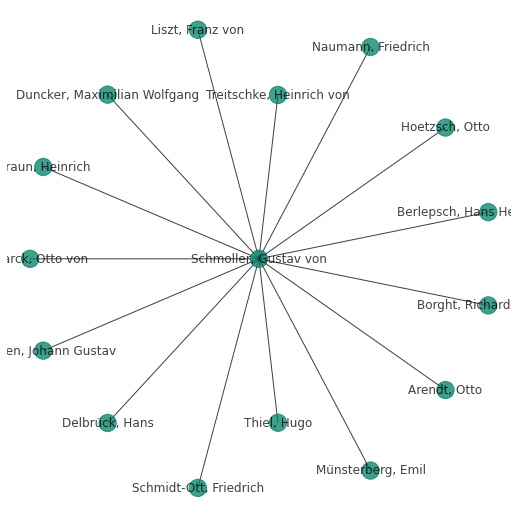

In [151]:
from itertools import count

pos = nx.kamada_kawai_layout(G)
plt.rcParams['figure.figsize'] = [7, 7]

node_labels_names = nx.get_node_attributes(G, "Name")
node_labels_titles = nx.get_node_attributes(G, "Title")
node_labels = {**node_labels_names, **node_labels_titles}

groups = set(nx.get_node_attributes(G,'type').values())
mapping = dict(zip(sorted(groups),count()))
color_map = [mapping[G.nodes()[n]['type']] for n in G.nodes()]

node_types = nx.get_node_attributes(G, "type")

edge_labels = nx.get_edge_attributes(G, "SourceType")

nx.draw(G, pos = pos, labels = node_labels, alpha = 0.75, node_color = color_map, cmap = plt.cm.summer)
#nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, label_pos=0.5)

plt.show()

Schmoller is directly connected to 15 politicians that have a connection to Berlin. Let's investigate now, what these relationships are about.

We can use the `SourceType` attribute of the edges to get a better understanding of how the nodes are connected:

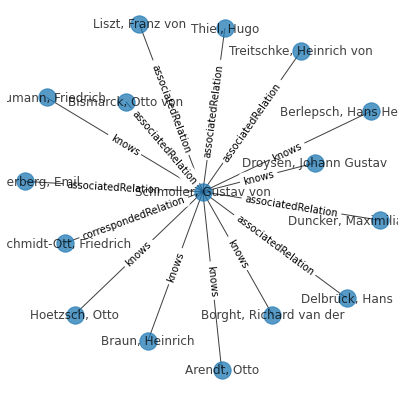

In [149]:
pos = nx.spring_layout(G,  seed = 42)
plt.rcParams['figure.figsize'] = [7, 7]

node_labels_names = nx.get_node_attributes(G, "Name")
node_labels_titles = nx.get_node_attributes(G, "Title")
node_labels = {**node_labels_names, **node_labels_titles}

edge_labels = nx.get_edge_attributes(G, "SourceType")

nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels, label_pos=0.5)
nx.draw(G, pos = pos, labels = node_labels, alpha = 0.75, cmap = plt.cm.summer)


plt.show()

We are analyzing the `SocialRelations` of Schmoller. The social relations in the SoNAR (IDH) database have very specific characteristics since they are derived from resources like diaries or letters. We retrieved three different types of social relations for Schmoller, namely `knows`, `associatedRelation` and `correspondedRelation`. The table below provides some information on what these relationship types mean:


|Type|Meaning|
|:--|--|
|`knows`|Derived from diary entries, albums or family registers|
|`associatedRelation`|Inference of a social relation|
|`correspondedRelation`| Derived from letters and other correspondences|

In [150]:
target_person = "Duncker, Maximilian Wolfgang"

relation = [attribute["Source"] for source, target, attribute in G.edges(data=True) if (G.nodes(data=True)[source]["Id"] == "(DE-588)118609378") and (G.nodes(data=True)[target]["Name"] == target_person)]
schmoller_id = [x for x,y in G.nodes(data=True) if y['Id']=="(DE-588)118609378"]

In [21]:
relation

['BibGBV136639283']

In [19]:
%%time

query = """
MATCH (res:Resource)-[r]-(n:PerName)
WHERE (res.id = "{relation}")
OPTIONAL MATCH (n)-[r2:RelationToGeoName]-(g:GeoName)
WHERE g.Name CONTAINS "Berlin"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

test = to_nx_graph(neo4j_driver = driver, 
                query = query.format(relation = relation[0]))

Failed to read from defunct connection IPv4Address(('h2918680.stratoserver.net', 7687)) (IPv4Address(('85.214.119.41', 7687)))


ServiceUnavailable: Failed to read from defunct connection IPv4Address(('h2918680.stratoserver.net', 7687)) (IPv4Address(('85.214.119.41', 7687)))

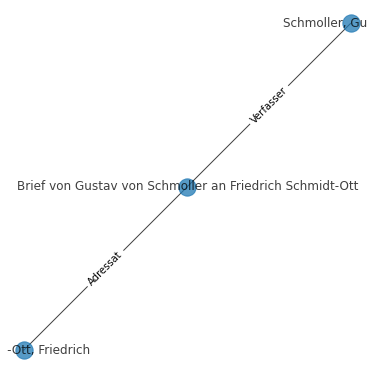

In [272]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(test,  seed = 42)
plt.rcParams['figure.figsize'] = [5, 5]
#plt.figure()    

node_labels_names = nx.get_node_attributes(test, "Name")
node_labels_titles = nx.get_node_attributes(test, "Title")
node_labels = {**node_labels_names, **node_labels_titles}

edge_labels = nx.get_edge_attributes(test, "TypeAddInfo")

nx.draw(test, pos = pos, labels = node_labels, alpha = 0.75)
nx.draw_networkx_edge_labels(test,pos,edge_labels=edge_labels, label_pos=0.5)

plt.show()

# How does the academic network of Schmoller look like?

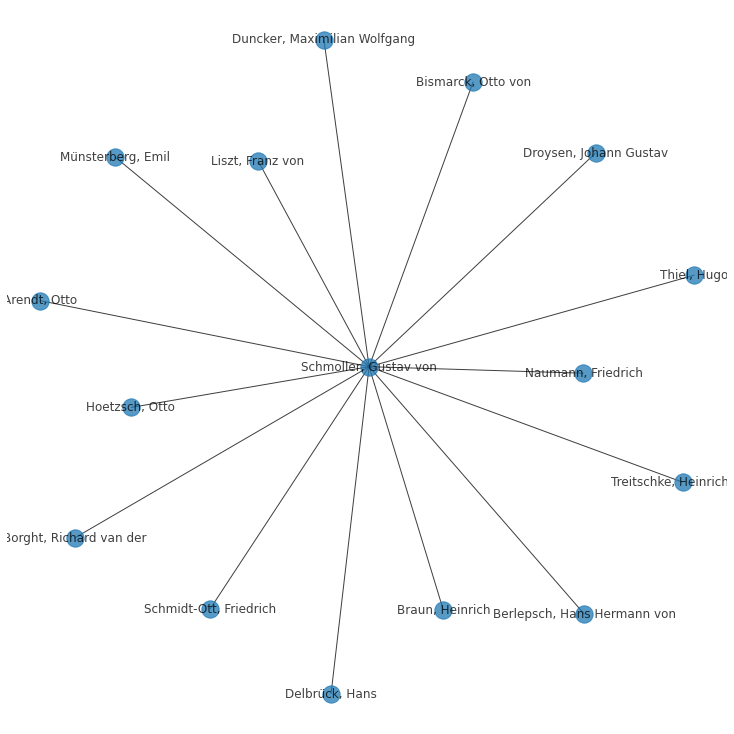

In [222]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [10, 10]
labels = nx.get_node_attributes(G, "Name")

nx.draw(G, labels = labels, alpha = 0.75)


In [9]:
driver = GraphDatabase.driver(uri, auth=(user, password))

query = """
MATCH (n:PerName)-[rel:SocialRelation]-(n2:PerName)-[rel2]-(t:TopicTerm)
WHERE n.Id = "(DE-588)118609378"
RETURN *
"""

driver = GraphDatabase.driver(uri, auth=(user, password))

G = to_nx_graph(neo4j_driver = driver, 
                query = query)

In [68]:
relations = [attribute for source, target, attribute in G.edges(data=True) if G.nodes(data=True)[source]["Id"] == "(DE-588)118609378"]
schmoller_id = [x for x,y in G.nodes(data=True) if y['Id']=="(DE-588)118609378"]

In [71]:
relation_types = [relation["SourceType"] for relation in relations]
set(relation_types)

{'associatedRelation', 'correspondedRelation', 'knows'}

In [74]:
relations_ids = [relation["Source"] for relation in relations]

In [51]:
print(G.nodes(data=True)[connections[2][0]])
print([connections[2][1]])

{'label': 'Klein, Felix', 'type': 'PerName', 'GenType': 'p', 'DateApproxEnd': '1925', 'DateStrictOriginal': '25.04.1849-22.06.1925', 'VariantName': 'Klein, Christian Felix;;;Klein, F.;;;Klejn, F.;;;Kurain, F.;;;Klein, Félix', 'SpecType': 'piz', 'DateStrictBegin': '25.04.1849', 'DateStrictEnd': '22.06.1925', 'DateApproxOriginal': '1849-1925', 'Gender': '1', 'Uri': 'http://d-nb.info/gnd/11856286X', 'Name': 'Klein, Felix', 'DateApproxBegin': '1849', 'Id': '(DE-588)11856286X', 'id': 'Aut11856286X'}
[{'key': 126436727, 'title': 'SocialRelation', 'Source': 'BibDE_611_HS_3191983', 'TypeAddInfo': 'undirected', 'SourceType': 'associatedRelation'}]


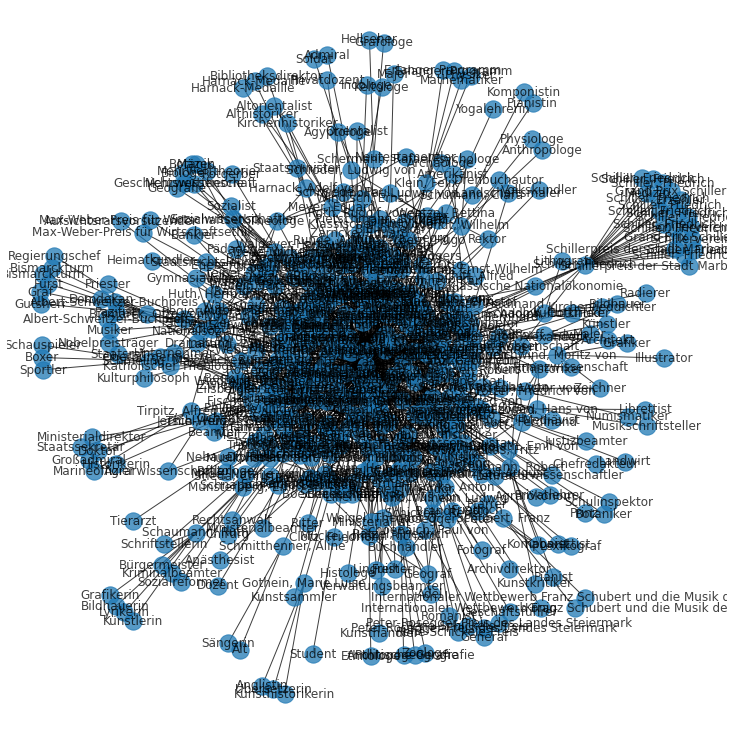

In [62]:
#list(G.edges(data=True))[]
subgraph = G.subgraph(connections.append(schmoller_id))

import matplotlib.pyplot as plt
import networkx as nx

plt.rcParams['figure.figsize'] = [10, 10]
labels = nx.get_node_attributes(subgraph, "Name")

nx.draw(subgraph, labels = labels, alpha = 0.75)


In [60]:
[x for x,y in G.nodes(data=True) if y['Id']=="(DE-588)118609378"]

NameError: name 'y' is not defined